In [1]:
import numpy as np
from numpy import mean,std, dstack
import pandas as pd
from pandas import read_csv
import seaborn as sns

import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, LSTM
from tensorflow.keras.layers import concatenate, Dropout
from keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.utils import to_categorical

In [2]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    feature_name_df = pd.read_csv('./data/HAR/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    

    X_train = pd.read_csv('./data/HAR/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./data/HAR/test/X_test.txt',sep='\s+', names=feature_name)
    

    y_train = pd.read_csv('./data/HAR/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./data/HAR/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = get_human_dataset()

In [4]:
batch_size = 64
validation_split = 0.2

In [5]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):

        end_ix = i + n_steps

        if end_ix > len(sequences):
            break

        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [6]:
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

X_train, y_train = split_sequences(train_set, 30)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 30)
print(X_test.shape, y_test.shape)

(7323, 30, 561) (7323,)
(2918, 30, 561) (2918,)


In [7]:
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

(7323, 7)
(2918, 7)


In [21]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(LSTM(256, return_sequences=True))
model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 128)           353280    
                                                                 
 lstm_5 (LSTM)               (None, 30, 256)           394240    
                                                                 
 conv1d_4 (Conv1D)           (None, 27, 128)           131200    
                                                                 
 conv1d_5 (Conv1D)           (None, 24, 64)            32832     
                                                                 
 flatten_1 (Flatten)         (None, 1536)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1536)              0         
                                                                 
 dense_4 (Dense)             (None, 32)               

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
train_epochs = 50
history = model.fit(X_train, y_train, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/50
92/92 [==============================] - 30s 328ms/step - loss: 0.7047 - accuracy: 0.7101 - val_loss: 0.6205 - val_accuracy: 0.7454
Epoch 2/50
92/92 [==============================] - 28s 305ms/step - loss: 0.3611 - accuracy: 0.8617 - val_loss: 0.3476 - val_accuracy: 0.8908
Epoch 3/50
92/92 [==============================] - 28s 308ms/step - loss: 0.2006 - accuracy: 0.9295 - val_loss: 0.2259 - val_accuracy: 0.9242
Epoch 4/50
92/92 [==============================] - 28s 303ms/step - loss: 0.1258 - accuracy: 0.9575 - val_loss: 0.1373 - val_accuracy: 0.9488
Epoch 5/50
92/92 [==============================] - 32s 344ms/step - loss: 0.0522 - accuracy: 0.9811 - val_loss: 0.0903 - val_accuracy: 0.9659
Epoch 6/50
92/92 [==============================] - 31s 342ms/step - loss: 0.0451 - accuracy: 0.9840 - val_loss: 0.1139 - val_accuracy: 0.9625
Epoch 7/50
92/92 [==============================] - 30s 326ms/step - loss: 0.0721 - accuracy: 0.9761 - val_loss: 0.0882 - val_accuracy: 0.9604

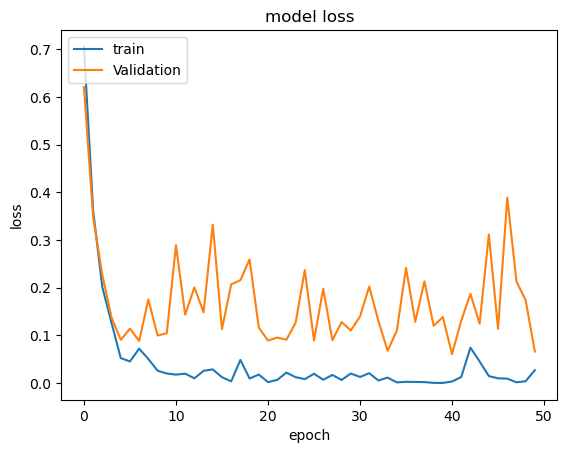

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [27]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM+CNN model", test_accuracy)
predictions = model.predict(X_test)

Accuracy of the LSTM+CNN model 0.9742974638938904
92/92 [==============================] - 22s 147ms/step


In [28]:
predictions

array([[4.96647745e-09, 9.11573636e-07, 1.94483323e-06, ...,
        9.38347504e-02, 9.06145275e-01, 1.71039173e-05],
       [1.26079713e-09, 1.61489126e-07, 6.61342995e-07, ...,
        2.32551005e-02, 9.76740181e-01, 3.92558559e-06],
       [8.91459706e-09, 4.08525375e-06, 5.98770384e-06, ...,
        4.08907413e-01, 5.90992868e-01, 8.95300545e-05],
       ...,
       [1.36493385e-08, 1.01634017e-04, 9.25772309e-01, ...,
        1.28670566e-04, 7.39970803e-02, 4.82286566e-08],
       [3.68800528e-07, 9.19449842e-04, 7.80017078e-01, ...,
        2.04339321e-03, 2.17007399e-01, 1.13967076e-06],
       [3.98641902e-07, 1.63847930e-03, 9.80256617e-01, ...,
        8.05184012e-04, 1.62864067e-02, 4.31470426e-06]], dtype=float32)

In [29]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y]

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[492   0   4   0   0   0]
 [  0 470   1   0   0   0]
 [  1  11 408   0   0   0]
 [  0   0   0 466  25   0]
 [  0   0   0  32 471   0]
 [  0   0   0   1   0 536]]
**** Classification Report ****
              precision    recall  f1-score   support

     Walking       1.00      0.99      0.99       496
      Walkup       0.98      1.00      0.99       471
    Walkdown       0.99      0.97      0.98       420
     Sitting       0.93      0.95      0.94       491
    Standing       0.95      0.94      0.94       503
      Laying       1.00      1.00      1.00       537

    accuracy                           0.97      2918
   macro avg       0.97      0.97      0.97      2918
weighted avg       0.97      0.97      0.97      2918



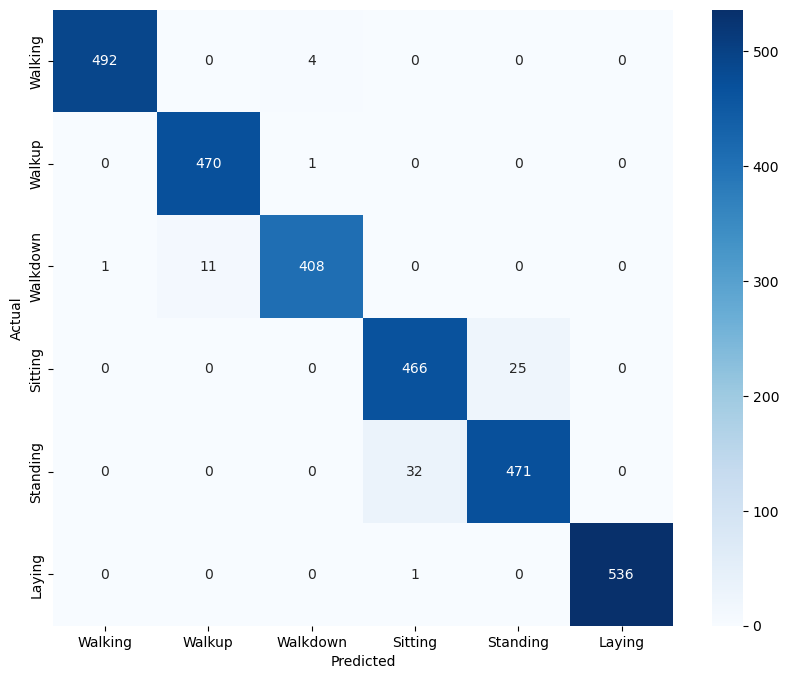

In [30]:
classNames=["Walking","Walkup","Walkdown","Sitting","Standing","Laying"]
display_results(y_test,predictions,classNames)